In [52]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import tiktoken
import matplotlib.pyplot as plt

from utils import (
    compute_batch_loss,
    evaluate_model,
    text_to_token_ids,
    token_ids_to_text,
    generate_text,
)

In [24]:
torch.cuda.is_available(), torch.cuda.get_device_name()

(True, 'NVIDIA T1200 Laptop GPU')

In [25]:
with open("./the_things.txt", encoding="utf-8") as file:
    raw_text = file.read()

len(raw_text)

39181

In [26]:
tokenizer = tiktoken.get_encoding("gpt2")

In [27]:
token_ids = tokenizer.encode(raw_text)
len(token_ids)

9275

In [28]:
class BookDataset(Dataset):
    def __init__(self, token_ids, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        for i in range(0, len(token_ids) - max_length, stride):
            self.input_ids.append(torch.tensor(token_ids[i : i + max_length]))
            self.target_ids.append(torch.tensor(token_ids[i + 1 : i + 1 + max_length]))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]

In [29]:
split_ratio = 0.85
split_index = int(split_ratio * len(raw_text))

In [30]:
train_tokens = tokenizer.encode(raw_text[:split_index])
valid_tokens = tokenizer.encode(raw_text[split_index:])

In [31]:
train_ds = BookDataset(train_tokens, 256, 128)
valid_ds = BookDataset(valid_tokens, 256, 128)

In [32]:
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_ds, batch_size=4, shuffle=False, drop_last=False)

In [33]:
GPT_CONFIG = {
    "vocab_size": tokenizer.n_vocab,
    "context_length": 256,
    "embed_dim": 768,
    "num_heads": 12,
    "num_layers": 12,
    "dropout_rate": 0.1,
    "qkv_bias": False,
}

In [34]:
class MultiHeadAttention(nn.Module):
    def __init__(
        self, in_dim, out_dim, context_length, dropout, num_heads, qkv_bias=False
    ):
        super().__init__()
        assert out_dim % num_heads == 0, "out_dim must be divisible by num_heads"

        self.out_dim = out_dim
        self.num_heads = num_heads
        self.head_dim = out_dim // num_heads

        self.query_weight = nn.Linear(in_dim, out_dim, bias=qkv_bias)
        self.key_weight = nn.Linear(in_dim, out_dim, bias=qkv_bias)
        self.value_weight = nn.Linear(in_dim, out_dim, bias=qkv_bias)

        self.output_projection = nn.Linear(out_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        batch_size, num_tokens, in_dim = x.shape

        keys = self.key_weight(x)
        queries = self.query_weight(x)
        values = self.value_weight(x)

        # Split the weights to have qkv for each head
        keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attention_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attention_scores = attention_scores.masked_fill(mask_bool, -torch.inf)

        attention_weights = torch.softmax(
            attention_scores / keys.shape[-1] ** 0.5, dim=-1
        )
        attention_weights = self.dropout(attention_weights)

        context_vector = (attention_weights @ values).transpose(1, 2)
        context_vector = context_vector.contiguous().view(
            batch_size, num_tokens, self.out_dim
        )
        context_vector = self.output_projection(context_vector)

        return context_vector

In [35]:
class LayerNorm(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()

        self.epsilon = 1e-5
        self.scale = nn.Parameter(torch.ones(embed_dim))
        self.shift = nn.Parameter(torch.zeros(embed_dim))

    def forward(self, x):
        x_mean = x.mean(dim=-1, keepdim=True)
        x_variance = x.var(dim=-1, keepdim=True)
        x_norm = (x - x_mean) / torch.sqrt(x_variance + self.epsilon)

        return self.scale * x_norm + self.shift

In [36]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return (
            0.5
            * x
            * (
                1
                + torch.tanh(
                    torch.sqrt(torch.tensor(2.0 / torch.pi))
                    * (x + 0.044715 * torch.pow(x, 3))
                )
            )
        )

In [37]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            GELU(),
            nn.Linear(4 * embed_dim, embed_dim),
        )

    def forward(self, x):
        return self.layers(x)

In [38]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.mha = MultiHeadAttention(
            in_dim=config["embed_dim"],
            out_dim=config["embed_dim"],
            context_length=config["context_length"],
            dropout=config["dropout_rate"],
            num_heads=config["num_heads"],
            qkv_bias=config["qkv_bias"],
        )

        self.ffn = FeedForward(config["embed_dim"])

        self.norm1 = LayerNorm(config["embed_dim"])
        self.norm2 = LayerNorm(config["embed_dim"])

        self.shortcut_dropout = nn.Dropout(config["dropout_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.mha(x)
        x = self.shortcut_dropout(x)
        x += shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.shortcut_dropout(x)
        x += shortcut

        return x

In [39]:
class BookGPT(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.token_embedding = nn.Embedding(config["vocab_size"], config["embed_dim"])
        self.position_embedding = nn.Embedding(
            config["context_length"], config["embed_dim"]
        )

        self.dropout = nn.Dropout(config["dropout_rate"])

        self.transformers = nn.Sequential(
            *[Transformer(config) for _ in range(config["num_layers"])]
        )

        self.norm = LayerNorm(config["embed_dim"])
        self.out_head = nn.Linear(config["embed_dim"], config["vocab_size"], bias=False)

    def forward(self, x):
        batch_size, seq_len = x.shape

        token_embeds = self.token_embedding(x)
        position_embeds = self.position_embedding(
            torch.arange(seq_len, device=x.device)
        )

        x = token_embeds + position_embeds
        x = self.dropout(x)
        x = self.transformers(x)
        x = self.norm(x)
        logits = self.out_head(x)

        return logits

In [ ]:
model = BookGPT(GPT_CONFIG)
model.to("cuda")

In [41]:
train_losses, valid_losses, track_tokens_seen = [], [], []
tokens_seen = 0
global_step = -1

In [42]:
num_epochs = 10
optimizer = torch.optim.AdamW(params=model.parameters(), lr=5e-4, weight_decay=0.1)
eval_freq = 10
eval_iter = 5

In [43]:
for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:

        optimizer.zero_grad()

        loss = compute_batch_loss(input_batch, target_batch, model)
        loss.backward()

        optimizer.step()

        tokens_seen += input_batch.numel()
        global_step += 1

        if global_step % eval_freq == 0:
            train_loss, valid_loss = evaluate_model(
                train_loader, valid_loader, model, eval_iter
            )

            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            track_tokens_seen.append(tokens_seen)

            print(
                f"Epoch {epoch+1} (Step {global_step:06d}): "
                f"Train loss {train_loss:.3f}, Val loss {valid_loss:.3f}"
            )

Ep 1 (Step 000000): Train loss 9.485, Val loss 9.422
Ep 1 (Step 000010): Train loss 6.167, Val loss 6.735
Ep 2 (Step 000020): Train loss 5.672, Val loss 6.678
Ep 3 (Step 000030): Train loss 4.980, Val loss 6.459
Ep 3 (Step 000040): Train loss 3.905, Val loss 6.387
Ep 4 (Step 000050): Train loss 3.351, Val loss 6.412
Ep 5 (Step 000060): Train loss 2.731, Val loss 6.451
Ep 6 (Step 000070): Train loss 1.895, Val loss 6.509
Ep 6 (Step 000080): Train loss 1.437, Val loss 6.669
Ep 7 (Step 000090): Train loss 0.939, Val loss 6.802
Ep 8 (Step 000100): Train loss 0.674, Val loss 6.960
Ep 8 (Step 000110): Train loss 0.421, Val loss 7.040
Ep 9 (Step 000120): Train loss 0.327, Val loss 7.253
Ep 10 (Step 000130): Train loss 0.196, Val loss 7.386


In [44]:
torch.save(model.state_dict(), "./weights/book_gpt.pth")

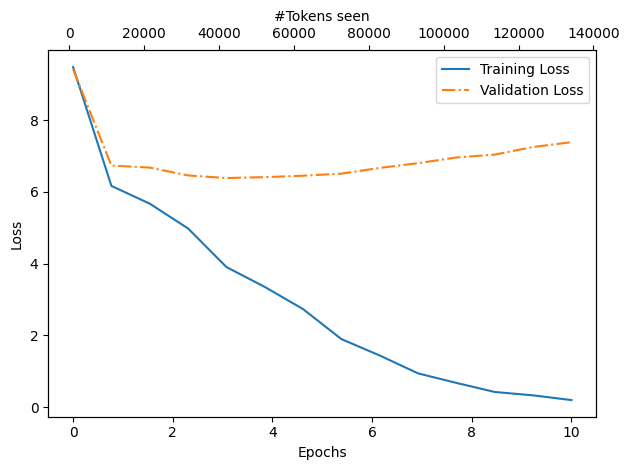

In [46]:
fig, ax1 = plt.subplots()

epochs_seen = torch.linspace(0, num_epochs, len(train_losses))

ax1.plot(epochs_seen, train_losses, label="Training Loss")
ax1.plot(epochs_seen, valid_losses, linestyle="-.", label="Validation Loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")

ax2 = ax1.twiny()
ax2.plot(track_tokens_seen, train_losses, alpha=0)
ax2.set_xlabel("#Tokens seen")

fig.tight_layout()
plt.show()

## Demo

In [56]:
sample = "The world has found me out"
input_ids = text_to_token_ids(sample, tokenizer)

In [57]:
checkpoint = torch.load("./weights/book_gpt.pth")
model = BookGPT(GPT_CONFIG)
model.load_state_dict(checkpoint)
model.eval()

C:\Users\SaiPraneethDiddigam\AppData\Local\Temp\ipykernel_15816\3236077247.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./weights/book_gpt.pt

BookGPT(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(256, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformers): Sequential(
    (0): Transformer(
      (mha): MultiHeadAttention(
        (query_weight): Linear(in_features=768, out_features=768, bias=False)
        (key_weight): Linear(in_features=768, out_features=768, bias=False)
        (value_weight): Linear(in_features=768, out_features=768, bias=False)
        (output_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (shortcut_dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Transformer(
      (mha): MultiHeadAttention(


In [70]:
output_ids = generate_text(
    model, input_ids, max_tokens=200, context_length=100, temperature=0.3
)

In [71]:
generated_text = token_ids_to_text(output_ids, tokenizer)

In [72]:
with open("./generated.txt", "w") as file:
    file.write(generated_text)